In [160]:
%load_ext autoreload
%autoreload 2
import data_loader
from feature_extraction import extract_features, data_in_tw
import matplotlib.pyplot as plt

#from datetime import datetime, timedelta
import pandas as pd
import pytz
import pickle

from sklearn.svm import SVC

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
# Size of time window in unit of second.
TIME_WINDOW_SEC = 30
features = []
labels = []

# Data Loading

In [162]:
dl = data_loader.DataLoader()

# Load Groudtruth
df_labels = dl.load_groundtruth()


# Load low frequency data
df_location = dl.load_low_freq_data('LOCATION')
df_activity = dl.load_low_freq_data('ACTIVITY_TYPE')

Loading /Users/zxxia/Research/bharath-data/lowfreqdata/10_null_LOCATION_null_PHONE_null_null_org.md2k.phonesensor_null_DATA.csv...
Loading /Users/zxxia/Research/bharath-data/lowfreqdata/11_null_ACTIVITY_TYPE_null_PHONE_null_null_org.md2k.phonesensor_null_DATA.csv...


In [163]:
visited = set()
_, _, beacon_id_set = dl.load_datasources()

for index, row in df_labels.iterrows():
    d = row['Start Timestamp'].date()
    if d not in visited:
        # load high frequency data
        df_battery = dl.load_high_freq_data('BATTERY', d)
        df_compass = dl.load_high_freq_data('COMPASS', d)
        df_ambient_light = dl.load_high_freq_data('AMBIENT_LIGHT', d)
        beacon_dfs = []
        for beacon_id in beacon_id_set:
            beacon_dfs.append(dl.load_high_freq_data('BEACON', d, beacon_id))
        if not beacon_dfs:
            df_beacon = None
        else:
            df_beacon = pd.concat(beacon_dfs)
            df_beacon.sort_values(by=['Timestamp'])
        
        visited.add(d)

    start = row['Start Timestamp']
    end = row['End Timestamp']

    if start >= end:
        continue

    # Obtain data needed for one label(one event)
    streams = dict()
    streams['Battery'] = data_in_tw(df_battery, start, end)
    streams['Compass'] = data_in_tw(df_compass, start, end)
    streams['Activity'] = data_in_tw(df_activity, start, end)
    streams['Location'] = data_in_tw(df_location, start, end)
    streams['Ambient Light'] = data_in_tw(df_ambient_light, start, end)
    streams['Beacon'] = data_in_tw(df_beacon, start, end)

    # Segment data streams into time windows, extract features and append features
    tmp = extract_features(streams, start, end, TIME_WINDOW_SEC)
    features = features + tmp
    
    # Extract labels and append labels
    labels = labels + [row['Labels']] * len(tmp)

Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012000_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012001_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012002_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012003_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012004_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012005_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012006_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012007_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012008_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012009_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012010_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012011_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012012_9.csv.gz...
Loading /Users/zxxia/Rese

Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012121_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012122_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012123_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012111_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012112_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012113_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012114_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012115_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012116_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012117_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012118_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012119_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012120_14.csv.gz...
Loadi

Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012101_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012102_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012103_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012104_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012105_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012106_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012107_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012108_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012109_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012110_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012111_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012112_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw22

Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012205_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012206_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012207_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012208_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012209_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012217_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012220_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012221_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012222_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012223_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw439/2018012220_439.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw448/2018012220_448.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw44

Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012312_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012313_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012314_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012315_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012316_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012317_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012318_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012319_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012320_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012321_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012322_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw14/2018012323_14.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw15/2018012309_15.csv.gz...

Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012310_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012311_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012312_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012316_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw221/2018012323_221.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw478/2018012316_478.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw464/2018012316_464.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw492/2018012321_492.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw475/2018012316_475.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw457/2018012316_457.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012400_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/2018012401_9.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw9/20180124

Loading /Users/zxxia/Research/bharath-data/raw/raw514/2018012420_514.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw509/2018012419_509.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw516/2018012420_516.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw519/2018012423_519.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012400_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012401_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012406_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012407_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012419_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012420_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw53/2018012423_53.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw502/2018012416_502.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw517/2018012421_5

Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012502_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012503_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012504_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012505_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012506_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012507_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012508_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012509_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012510_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw222/2018012511_222.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw536/2018012515_536.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw223/2018012500_223.csv.gz...
Loading /Users/zxxia/Research/bharath-data/raw/raw22

In [164]:
print(len(features))
print(len(labels))

15107
15107


# Data Preprocessing

In [173]:
# Convert features and labels to pandas dataframe format
df_features = pd.DataFrame(features)
df_features['Labels'] = pd.DataFrame(labels)

#df_features.to_csv('bharath_features_labels.csv')

df_features['Battery Charging'].interpolate(method='nearest', inplace=True)
# df_features['Max GPS Accuracy'].fillna(500, inplace=True)
df_features['Max GPS Accuracy'].interpolate(method='nearest', inplace=True)
df_features['Max GPS Speed'].interpolate(method='nearest', inplace=True)
#df_features.drop('Mean Battery Temperature', axis=1, inplace=True)
df_features.drop('Magnetic Field Variance', axis=1, inplace=True)
df_features.drop('Beacon', axis=1, inplace=True)
df_features = df_features.dropna(axis=0)

# Separate entire dataframe into different classes
df_incar = df_features[df_features.Labels=='Incar']
df_indoor = df_features[df_features.Labels=='Indoor']
df_outdoor = df_features[df_features.Labels=='Outdoor']


In [166]:
pd.set_option('display.max_rows', 1000)
display(df_features)
df_features[df_features['Beacon']==0].shape[0] == 0

,Battery Charging,Beacon,IN_VEHICLE,Max GPS Accuracy,Max GPS Speed,Max Light Intensity,ON_BICYCLE,ON_FOOT,RUNNING,STILL,TILTING,Time of day,UNKNOWN,WALKING,Labels
963,0.0,0,0,25.134001,0.000000,1.071991,0,0,0,1,0,8,0,0,Indoor
964,0.0,0,0,25.134001,0.000000,0.606995,0,0,0,1,0,8,0,0,Indoor
965,0.0,0,0,25.134001,0.000000,0.303986,0,0,0,1,0,8,0,0,Indoor
966,0.0,0,0,25.134001,0.000000,0.454987,0,0,0,1,0,8,0,0,Indoor
967,0.0,0,0,25.134001,0.000000,0.454987,0,0,0,1,0,8,0,0,Indoor
1007,1.0,1,0,25.134001,0.000000,51.513992,0,0,0,1,0,8,0,0,Indoor
1046,1.0,1,0,23.142000,0.000000,48.802994,0,0,0,1,0,8,0,0,Indoor
1047,1.0,1,0,23.142000,0.000000,79.981995,0,0,0,1,0,8,0,0,Indoor
1060,1.0,1,0,23.142000,0.000000,88.792999,0,0,0,1,0,8,0,0,Indoor
1061,1.0,1,0,23.142000,0.000000,105.060989,0,0,0,1,0,8,0,0,Indoor


False

In [167]:
print(df_indoor.shape)
print(df_outdoor.shape)
print(df_incar.shape)
print(df_labels.shape)
print(df_features.shape)

(1519, 15)
(329, 15)
(306, 15)
(107, 5)
(2154, 15)


In [168]:
# Downsample majority class
df_indoor = resample(df_indoor, 
                     replace=False,   # sample without replacement
                     n_samples=310,   # to match minority class
                     random_state=42) # reproducible results

df_features = pd.concat([df_indoor, df_outdoor, df_incar])

df_labels = df_features['Labels']
df_features.drop('Labels', axis=1, inplace=True)




# train_features is numpy array
vec = DictVectorizer()
train_features = vec.fit_transform(df_features.to_dict('records')).toarray()

# Normalize columns of features with min-max scaler
scaler = MinMaxScaler(copy=False)
train_features = scaler.fit_transform(train_features)

# Encode all features
le = LabelEncoder()
le.fit(['Incar', 'Indoor', 'Outdoor'])
train_labels = le.transform(df_labels)

# Training on SVM

## Tuning SVM Parameters

In [60]:
clf = SVC()
param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'kernel' : ['rbf','poly'],#, 'sigmoid', 
     'probability' : [True]}
]
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(train_features, train_labels)
print("Grid scores on development set:")

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print("Best parameters:", grid.best_params_)

Grid scores on development set:
0.363 (+/-0.002) for {'C': 0.001, 'kernel': 'rbf', 'probability': True}
0.363 (+/-0.002) for {'C': 0.001, 'kernel': 'poly', 'probability': True}
0.442 (+/-0.059) for {'C': 0.01, 'kernel': 'rbf', 'probability': True}
0.363 (+/-0.002) for {'C': 0.01, 'kernel': 'poly', 'probability': True}
0.721 (+/-0.217) for {'C': 0.1, 'kernel': 'rbf', 'probability': True}
0.363 (+/-0.002) for {'C': 0.1, 'kernel': 'poly', 'probability': True}
0.698 (+/-0.203) for {'C': 1, 'kernel': 'rbf', 'probability': True}
0.421 (+/-0.032) for {'C': 1, 'kernel': 'poly', 'probability': True}
0.702 (+/-0.227) for {'C': 10, 'kernel': 'rbf', 'probability': True}
0.704 (+/-0.217) for {'C': 10, 'kernel': 'poly', 'probability': True}
0.703 (+/-0.233) for {'C': 100, 'kernel': 'rbf', 'probability': True}
0.715 (+/-0.201) for {'C': 100, 'kernel': 'poly', 'probability': True}
0.702 (+/-0.234) for {'C': 1000, 'kernel': 'rbf', 'probability': True}
0.703 (+/-0.233) for {'C': 1000, 'kernel': 'poly', 

In [174]:
# 10 fold corss validation
clf = SVC(C=0.1, kernel='rbf')
#clf.fit(train_features, train_labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusionmatrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', confusionmatrix)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Micro F1 Score:', f1_score(y_test, y_pred, average='micro'))
    print('Macro F1 Score:', f1_score(y_test, y_pred, average='macro'))
    print('Weighted F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('\n')


Confusion Matrix:
 [[22  5  1]
 [ 0 28  6]
 [ 1  8 24]]
Accuracy: 0.778947368421
Micro F1 Score: 0.778947368421
Macro F1 Score: 0.786470588235
Weighted F1 Score: 0.782037151703


Confusion Matrix:
 [[23  7  0]
 [ 1 21  5]
 [ 0 10 28]]
Accuracy: 0.757894736842
Micro F1 Score: 0.757894736842
Macro F1 Score: 0.762246030791
Weighted F1 Score: 0.768142530396


Confusion Matrix:
 [[25  2  1]
 [ 0 25  5]
 [ 0 11 26]]
Accuracy: 0.8
Micro F1 Score: 0.8
Macro F1 Score: 0.810771177489
Weighted F1 Score: 0.803768166737


Confusion Matrix:
 [[19  2  2]
 [ 1 31  7]
 [ 0 15 18]]
Accuracy: 0.715789473684
Micro F1 Score: 0.715789473684
Macro F1 Score: 0.732121536131
Weighted F1 Score: 0.71493352467


Confusion Matrix:
 [[19  5  5]
 [ 2 24  5]
 [ 0 14 21]]
Accuracy: 0.673684210526
Micro F1 Score: 0.673684210526
Macro F1 Score: 0.681670761671
Weighted F1 Score: 0.67811405664


Confusion Matrix:
 [[17  5  3]
 [ 0 30  4]
 [ 0 15 20]]
Accuracy: 0.712765957447
Micro F1 Score: 0.712765957447
Macro F1 Score: 0

# Training on Naive Bayes Classifier

In [175]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusionmatrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', confusionmatrix)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Micro F1 Score:', f1_score(y_test, y_pred, average='micro'))
    print('Macro F1 Score:', f1_score(y_test, y_pred, average='macro'))
    print('Weighted F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('\n')

Confusion Matrix:
 [[24  1  3]
 [ 2  7 25]
 [ 3  1 29]]
Accuracy: 0.631578947368
Micro F1 Score: 0.631578947368
Macro F1 Score: 0.604043700984
Weighted F1 Score: 0.588582962915


Confusion Matrix:
 [[24  6  0]
 [ 1 24  2]
 [ 0 34  4]]
Accuracy: 0.547368421053
Micro F1 Score: 0.547368421053
Macro F1 Score: 0.527339327339
Weighted F1 Score: 0.498238603502


Confusion Matrix:
 [[27  1  0]
 [17 10  3]
 [ 7  4 26]]
Accuracy: 0.663157894737
Micro F1 Score: 0.663157894737
Macro F1 Score: 0.63862251204
Weighted F1 Score: 0.64867462096


Confusion Matrix:
 [[22  1  0]
 [24  8  7]
 [14  2 17]]
Accuracy: 0.494736842105
Micro F1 Score: 0.494736842105
Macro F1 Score: 0.482203903333
Weighted F1 Score: 0.466915595902


Confusion Matrix:
 [[25  2  2]
 [18 10  3]
 [13  2 20]]
Accuracy: 0.578947368421
Micro F1 Score: 0.578947368421
Macro F1 Score: 0.566448801743
Weighted F1 Score: 0.570209838321


Confusion Matrix:
 [[23  0  2]
 [20 11  3]
 [14  2 19]]
Accuracy: 0.563829787234
Micro F1 Score: 0.56382978

# Random Forest Regressor

In [39]:
feature_num_rmse_list = []
feature_num_oobe_list = []
for max_feature_num in range(1, 6):
    avg_test_rmse_list = []
    oobe_list = []
    for tree_num in range(1, 20):
        print('Max feature number:', max_feature_num, 'Number of tree', tree_num)
        regr = RandomForestRegressor(n_estimators=tree_num,
                                     max_features=max_feature_num,
                                     max_depth=10,
                                     bootstrap=True,
                                     oob_score=True,
                                     random_state=0)
        
        
        kf = KFold(n_splits=10, random_state=0, shuffle=True)
        test_mse_list = []

        for train_index, test_index in kf.split(train_features):
            X_train, X_test = train_features[train_index], train_features[test_index]
            y_train, y_test = train_labels[train_index], train_labels[test_index]

            regr.fit(X_train, y_train)

            # Compute mse for test set
            y_test_pred = regr.predict(X_test)
            test_mse_list.append(mean_squared_error(y_test, y_test_pred))

        avg_test_rmse = np.sqrt(np.mean(test_mse_list))
            
        avg_test_rmse_list.append(avg_test_rmse)
        
        regr.fit(train_features, train_labels)
        oobe = 1 - regr.oob_score_
        oobe_list.append(oobe)

    feature_num_rmse_list.append(avg_test_rmse_list)
    feature_num_oobe_list.append(oobe_list)

Max feature number: 1 Number of tree 1
Max feature number: 1 Number of tree 2
Max feature number: 1 Number of tree 3
Max feature number: 1 Number of tree 4


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 5


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 6


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 7
Max feature number: 1 Number of tree 8


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 9


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 10


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 11


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 12


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 13


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 14


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 15


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 16


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 17


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 1 Number of tree 18
Max feature number: 1 Number of tree 19
Max feature number: 2 Number of tree 1
Max feature number: 2 Number of tree 2
Max feature number: 2 Number of tree 3


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 4
Max feature number: 2 Number of tree 5


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 6
Max feature number: 2 Number of tree 7


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 8


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 9


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 10


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 11


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 12


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 13


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 14


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 15


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 16


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 17


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 2 Number of tree 18
Max feature number: 2 Number of tree 19
Max feature number: 3 Number of tree 1
Max feature number: 3 Number of tree 2
Max feature number: 3 Number of tree 3


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 4
Max feature number: 3 Number of tree 5


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 6
Max feature number: 3 Number of tree 7


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 8
Max feature number: 3 Number of tree 9


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 10


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 11


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 12


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 13


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 14


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 15


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 16


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 17


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 3 Number of tree 18
Max feature number: 3 Number of tree 19
Max feature number: 4 Number of tree 1
Max feature number: 4 Number of tree 2
Max feature number: 4 Number of tree 3
Max feature number: 4 Number of tree 4


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 5
Max feature number: 4 Number of tree 6


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 7
Max feature number: 4 Number of tree 8


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 9
Max feature number: 4 Number of tree 10


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 11


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 12


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 13


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 14


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 15


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 16


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 17


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 4 Number of tree 18
Max feature number: 4 Number of tree 19
Max feature number: 5 Number of tree 1
Max feature number: 5 Number of tree 2
Max feature number: 5 Number of tree 3
Max feature number: 5 Number of tree 4


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 5
Max feature number: 5 Number of tree 6


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 7
Max feature number: 5 Number of tree 8


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 9
Max feature number:

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

 5 Number of tree 10
Max feature number: 5 Number of tree 11


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 12


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 13


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 14


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 15


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 16


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 17


/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  

Max feature number: 5 Number of tree 18
Max feature number: 5 Number of tree 19


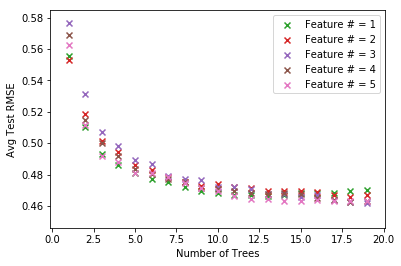

In [44]:
for i in range(len(feature_num_rmse_list)):
    plt.scatter(range(1,20), feature_num_rmse_list[i], marker='x', label='Feature # = {0}'.format(i + 1))
plt.xlabel('Number of Trees')
plt.ylabel('Avg Test RMSE')
plt.legend()
plt.show()

In [16]:
from hmmlearn.hmm import GaussianHMM
model = GaussianHMM(n_components=3)
model.fit(train_features)
pred_labels = model.predict(train_features)
for y_pred, y_true in zip(pred_labels, train_labels):
    print(y_pred, y_true)

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/zxxia/anaconda3/lib/python3.6/site-package

2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
1 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
0 1
2 1
2 1
2 1
2 1
1 1
2 1
2 1
2 1
2 1
2 1
2 1
2 1


In [61]:
# 10 fold corss validation
clf = SVC(C=0.1, kernel='rbf')
clf.fit(train_features, train_labels)

filename = '../zhengxuxia-data/zhengxux_features_labels.csv'
df_features_zhengxux = pd.read_csv(filename)
df_features_zhengxux.drop('Unnamed: 0', axis=1, inplace=True)

df_features_zhengxux['Battery Charging'].interpolate(method='nearest', inplace=True)
df_features_zhengxux['Max GPS Accuracy'].fillna(500, inplace=True)
df_features_zhengxux = df_features_zhengxux.dropna(axis=0)
df_labels_zhengxux = df_features_zhengxux['Labels']
df_features_zhengxux.drop('Labels', axis=1, inplace=True)

# train_features is numpy array
vec = DictVectorizer()
train_features = vec.fit_transform(df_features_zhengxux.to_dict('records')).toarray()

# Normalize columns of features with min-max scaler
scaler = MinMaxScaler(copy=False)
train_features = scaler.fit_transform(train_features)

# Encode all features
le = LabelEncoder()
le.fit(['Incar', 'Indoor', 'Outdoor'])
train_labels = le.transform(df_labels_zhengxux)

y_pred = clf.predict(train_features)
confusionmatrix = confusion_matrix(train_labels, y_pred)
print(confusionmatrix)

ValueError: X.shape[1] = 17 should be equal to 16, the number of features at training time

In [31]:
print('Accuracy:', accuracy_score(train_labels, y_pred))

Accuracy: 0.93993939668


In [9]:
# save the model to disk
filename = 'bhararh_model.clf'
pickle.dump(clf, open(filename, 'wb'))

In [15]:
# load the model from disk
filename = '../clf/zhengxuxia_model.clf'
zhengxux_model = pickle.load(open(filename, 'rb'))
y_pred = zhengxux_model.predict(train_features)
confusionmatrix = confusion_matrix(train_labels, y_pred)
print(confusionmatrix)
print(accuracy_score(train_labels, y_pred, normalize=True))
print(f1_score(train_labels, y_pred, average='micro'))
print(f1_score(train_labels, y_pred, average='macro'))
print(f1_score(train_labels, y_pred, average='weighted'))

[[ 372  184   28]
 [  44 9748  421]
 [   2  283  328]]
0.915687992989
0.915687992989
0.722944587432
0.917613942646


In [25]:
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit_transform(train_features)

ValueError: n_components must be < n_features; got 17 >= 17

In [24]:
print(svd.explained_variance_ratio_)
print(train_features.shape)

[  8.19503902e-02   2.68519859e-01   2.11723393e-01   1.14381935e-01
   1.00368488e-01   7.42230008e-02   6.51592453e-02   3.59981399e-02
   1.71882410e-02   1.24708370e-02   7.16832240e-03   4.71678926e-03
   3.25469560e-03   2.87666404e-03   7.33620520e-36   2.78095947e-64]
(11410, 17)
